*Note 1: This is the 2015-16 dataset. Lot of things might have been changed by now*

This notebook contains a short analysis of the literacy rate in Indian states and how it depends on the state's education indicators. I will be following CRISP-DM and will be marking my steps throughout the notebook.
The steps for CRISP-DM are as follows: 

1. Business understanding: outlining the questions we will answer along with why they are relevant and important
2. Data understanding: understanding the data and providing stats about it
3. Data preparation: showing how we clean and prepare the data
4. Data modeling: if we created a model, this is the section we would put it in of the analysis
5. Results evaluation: conclusion and discussion


In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
# Reading in datasets
elementary = pd.read_csv('data/2015_16_Statewise_Elementary.csv')
meta_elementary = pd.read_csv('data/2015_16_Statewise_Elementary_Metadata.csv')

Some functions that have been used throughout the notebook have been defined here:

## Defining functions

In [3]:
def sort_vals(df,col):
    '''
    sorts values according to the column provided in ascending order and returns a dataframe with 
    index reset
    
    INPUT:
    df - dataframe to be sorted
    col - column to be sorted on
    
    OUTPUT:
    df_new - sorted dataframe with index reset
    
    '''
    df_new = df.sort_values(by = col)
    df_new.reset_index().drop('index', axis = 1, inplace = True)
    return df_new

In [4]:
# We could just have used df.plot.barh method instead of the below. Both of these have the same output
def plot_barh(df, col1, col2, size = (10,10), title = None, xlabel = None):
    '''
    to make a horizontal barpot using any two columns(x and y axis) from a dataframe
    
    INPUT:
    df - dataframe that contains the data
    col1 - column for y-axis
    col2 - column for x-axis
    size - figsize attribute of the plot
    title - title of the plot
    xlabel - x-axis label of the plot
    
    '''
    fig, ax = plt.subplots(1,1,figsize = size)
    plt.barh(df[col1],df[col2],label = col2)
            
    if title:
        ax.set_title(title)   
    else:
        ax.set_title('{} vs {}'.format(col2, col1))
    if xlabel:
        ax.set_xlabel(xlabel)
    else:
        ax.set_xlabel(col2)

In [5]:
def display_desc(row):
    '''
    Displays the full string in the description column of the meta elementary dataset
    
    INPUT:
    row - (str) value of the field name you want the description for
    
    '''
    return meta_elementary[meta_elementary['Field name'] == row].Description.values[0]

## Exploring the data

Here, we are just taking a small look at the data to understand how to go about it working with it

In [6]:
# Checking the shape of the datasets
print(elementary.shape)
print(meta_elementary.shape)

(36, 816)
(816, 2)


In [7]:
# Quick check for null entries
print(elementary.isnull().sum()[elementary.isnull().sum() > 0].shape)

(0,)


In [8]:
elementary.head(2)

,AC_YEAR,STATCD,STATNAME,DISTRICTS,BLOCKS,VILLAGES,CLUSTERS,TOTPOPULAT,P_URB_POP,POPULATION_0_6,...,USCR35,NOTCH_ASS,TCHINV,TOTCLS1G,TOTCLS2G,TOTCLS3G,TOTCLS4G,TOTCLS5G,TOTCLS6G,TOTCLS7G
0,2015-16,1,JAMMU & KASHMIR,22,201,7263,1628,12549,20.05,16.01,...,1014,20491,1946,41171,62474,7878,564,495,24326,2001
1,2015-16,2,HIMACHAL PRADESH,12,124,10120,2243,6857,8.69,11.14,...,652,36054,3053,38307,6930,6909,6498,5445,6151,2717


In [9]:
meta_elementary.head(2)

,Field name,Description
0,AC_YEAR,AC_YEAR: AC_YEAR
1,STATCD,Data Reported from: Data Reported from


We see that:
* elementary contains the different states along with their education indicator values.
* meta_elementary gives us the description of the various labels used in elementary.

### [Step 1] Business Understanding:

We will be trying to answer the following questions : 
1. Which states have the highest and the lowest literacy rates? 
2. How are the top 3 states different from the bottom 3 states and what factors can the bottom 3 states work on to increase their literacy rate?
3. Which class is the dropout rate maximum in ?

These questions help us not only in determining which states are the top and bottom 3 w.r.t. to overall literacy rate, but also in studying about factors that affect these states. The 3rd question is really important from the governments view as it gives us the class/age of the child where he/she is most likely to dropout and thus, that particluar age group can be targeted with highly personal and specialized incentives.

### [Step 2] Data Understanding:

Here will be trying to get a little better look at the data in elementary.

In [10]:
# The overall state literacy rate
elementary['OVERALL_LI'].describe()

count    36.000000
mean     78.309444
std       8.257752
min      63.820000
25%      70.937500
50%      78.480000
75%      86.287500
max      93.910000
Name: OVERALL_LI, dtype: float64

In [11]:
elementary.AREA_SQKM.describe()

count        36.000000
mean      94501.111111
std      102321.909726
min          32.000000
25%        9926.750000
50%       54578.000000
75%      140320.000000
max      342239.000000
Name: AREA_SQKM, dtype: float64

In [12]:
elementary.GROWTHRATE.describe()

count    36.000000
mean     19.990556
std      11.455856
min      -0.470000
25%      13.880000
50%      18.910000
75%      22.637500
max      55.500000
Name: GROWTHRATE, dtype: float64

In [13]:
elementary[elementary.GROWTHRATE == -0.47]

,AC_YEAR,STATCD,STATNAME,DISTRICTS,BLOCKS,VILLAGES,CLUSTERS,TOTPOPULAT,P_URB_POP,POPULATION_0_6,...,USCR35,NOTCH_ASS,TCHINV,TOTCLS1G,TOTCLS2G,TOTCLS3G,TOTCLS4G,TOTCLS5G,TOTCLS6G,TOTCLS7G
12,2015-16,13,NAGALAND,11,47,1478,125,1981,17.31,14.44,...,233,21056,1454,6588,6152,1772,167,256,3639,781


Its interesting to see that Nagaland had a negative growth rate for 2015-16

In [14]:
# difference between male and female literacy rates for each state
(elementary.MALE_LIT - elementary.FEMALE_LIT).describe()

count    36.000000
mean     13.893611
std       5.679685
min       3.390000
25%      10.130000
50%      13.720000
75%      18.182500
max      27.850000
dtype: float64

The standard deviation is pretty large for this and we see that that 50% of the states have difference in male and female literacy rate as more than 13.72 which to me, seems pretty high !

#### Let's go onto answer our questions now that we have got some insights about our data.

_Note : As data is clean, the 3rd step in CRISP-DM, data preparation will be written multiple times when we try to create new features_

## 1. Which states have the highest and lowest literacy rates ? 

*NOTE: Secondary and elementary have the same stats concerning literacy rates.*

In [15]:
# 'OVERALL_LI' is the overall literacy rate for each state
elementary = sort_vals(elementary, 'OVERALL_LI')

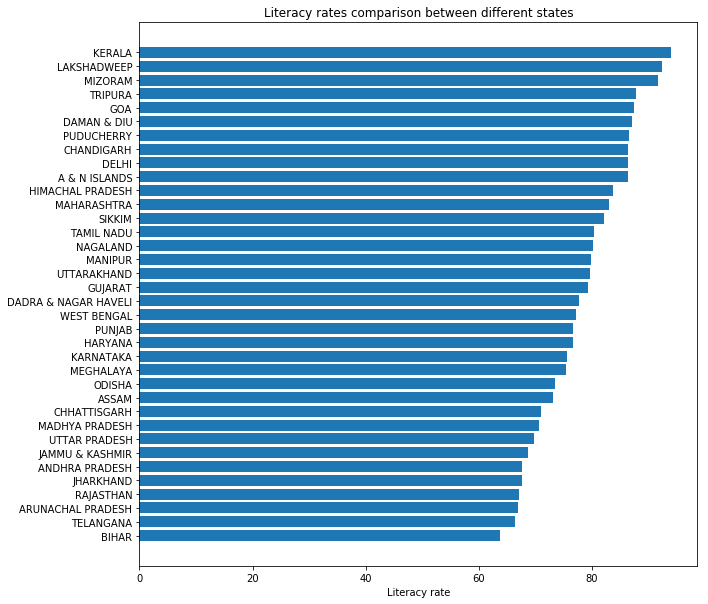

In [16]:
plot_barh(elementary, 'STATNAME', 'OVERALL_LI', title = 'Literacy rates comparison \
between different states' , xlabel = 'Literacy rate')

In [17]:
elementary = sort_vals(elementary, 'FEMALE_LIT')

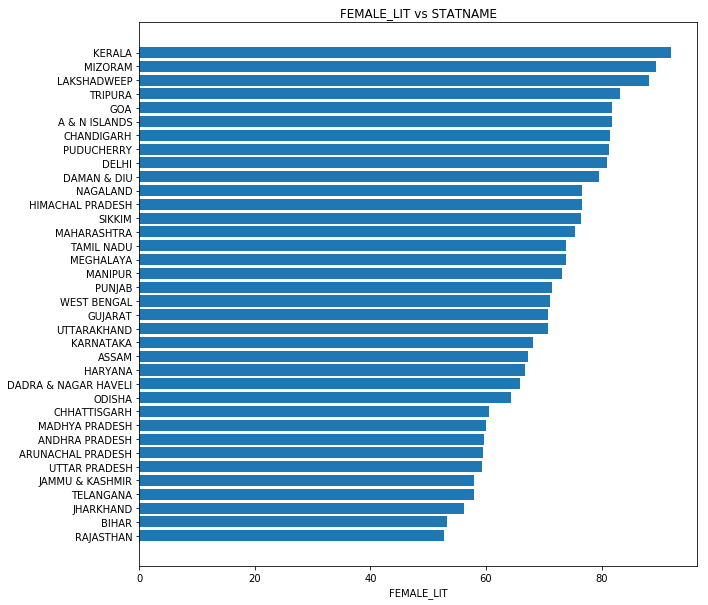

In [18]:
plot_barh(elementary, 'STATNAME', 'FEMALE_LIT')

In [19]:
elementary = sort_vals(elementary, 'MALE_LIT')

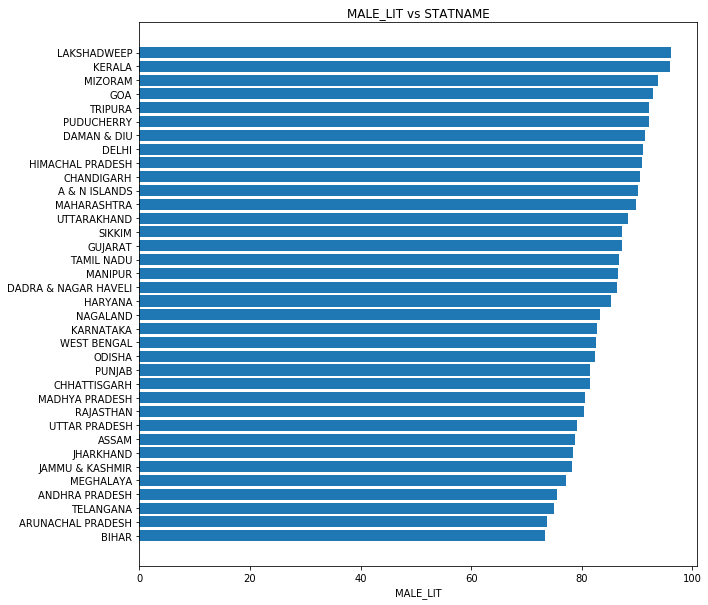

In [20]:
plot_barh(elementary, 'STATNAME', 'MALE_LIT')

We will now see a Male vs Female vs Literacy rate comparison

In [21]:
elementary = sort_vals(elementary, 'OVERALL_LI')

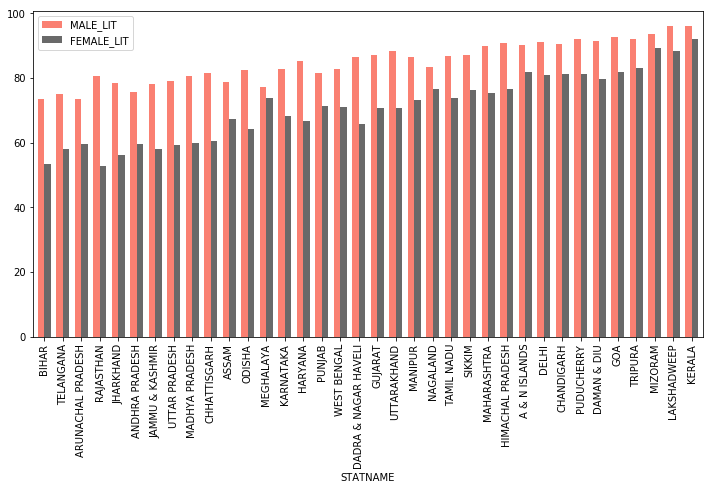

In [22]:
elementary.plot(kind = 'bar',x = 'STATNAME',y = ['MALE_LIT','FEMALE_LIT'],stacked = False,figsize=(12,6),width = 0.7,color = ['salmon','dimgrey'])

There are two things that could be interesting to explore:

1. Make a new column showing the the differences in literacy rates between men and women.
2. It looks like North-Eastern states on an average have less difference between male and female literacy rates. 

### [Step 3] Data Preparation:

Here we are going to create a new feature, DIFF_LIT, by subtracting the Female literacy rate from the male literacy rate. This will help us see the difference in male and female literacy rate for each state easily.

In [23]:
# Difference in Male and Female literacy rates
elementary['DIFF_LIT'] = elementary.MALE_LIT - elementary.FEMALE_LIT 

In [24]:
# Average difference in literacy rates
diff_lit_mean = elementary.DIFF_LIT.mean()
print("India's avg difference in literacy rate between men and women is : {}".format(diff_lit_mean))

India's avg difference in literacy rate between men and women is : 13.89361111111111


In [25]:
# States with the least male and female literacy rates difference
sort_vals(elementary, 'DIFF_LIT').head()[['STATNAME','DIFF_LIT']]

,STATNAME,DIFF_LIT
16,MEGHALAYA,3.39
31,KERALA,4.04
14,MIZORAM,4.32
12,NAGALAND,6.60
30,LAKSHADWEEP,7.86


In [26]:
# States with the most male and female literacy rates difference
sort_vals(elementary, 'DIFF_LIT').tail()[['STATNAME','DIFF_LIT']]

,STATNAME,DIFF_LIT
22,MADHYA PRADESH,20.51
25,DADRA & NAGAR HAVELI,20.53
21,CHHATTISGARH,20.86
19,JHARKHAND,22.24
7,RAJASTHAN,27.85


We now check out how the North-East Indian states perform compared to the National Average

In [27]:
# These are the Indian North-East states
north_east = ['NAGALAND','MANIPUR','MIZORAM','ASSAM','TRIPURA','ARUNACHAL PRADESH','MEGHALAYA','SIKKIM']
elementary.set_index(elementary.STATNAME,inplace = True)
ne_diff_lit_mean = elementary.loc[north_east,'DIFF_LIT' ].mean()
print('The avg in DIFF_LIT for north-eastern states ({}) is much less than the national avg ({}).'.format(ne_diff_lit_mean,diff_lit_mean))

The avg in DIFF_LIT for north-eastern states (9.1475) is much less than the national avg (13.89361111111111).


In [28]:
print("The Female literacy rate for meghalaya : {} .VS. the avg female literacy rate : {}".format(elementary.loc['MEGHALAYA','FEMALE_LIT'],elementary.FEMALE_LIT.mean()))

The Female literacy rate for meghalaya : 73.78 .VS. the avg female literacy rate : 71.0913888888889


We note the following from the above :

* The states with the highest overall literacy rates are : Kerala, Lakshwadeep, Mizoram, Tripura and Goa.
* The states with the lowest overall literacy rates are : Bihar, Telngana, Arunachal Pradesh, Rajasthan and Jharkhand. 
* Dadra and Nagar Haveli, Rajasthan, Chattisgarh, Jharkhand and MP have the maximum difference between Male and Female literacy rates. 
* Though the top states in male and female literacy remain the same but when we see the bottom states, they change. Meghalaya has the 5thhighest no. of illiterate males. The avg female literacy rate for Meghalaya though is higher than the avg female_lit rate.
* Also, the states with the highest overall literacy rates have really little differences between male and female literacy rates in general. We also see that states in North east have on an average lesser difference between male and female literacy rates when compared with the average of the country.

## 2. How are the top 3 states different from the bottom 3 states and what factors can the bottom 3 states work on to increase their literacy rate ? ( Explore using elementary dataset only)

For answering this question, we will carry out visual analyses using bar graphs on different features to see how they can affect Overall Literacy Rate

### [Step 3] Data Preparation:

We will be creating top_bottom, a dataframe that contains only the top 3 and bottom 3 states w.r.t. overal literacy rate. This will make plotting and analysis easy for us as we just have to explore these 6 states for answering this question.

In [29]:
# We will drop Telangana from bottom 3 as its been recently founded(2014)
top_3_elem = elementary.sort_values(by = 'OVERALL_LI', ascending = False).head(3)
bottom_3_elem = elementary.sort_values(by = 'OVERALL_LI', ascending = True).head(4).drop('TELANGANA',axis = 0)

In [30]:
top_bottom = pd.concat([top_3_elem, bottom_3_elem], axis = 0, sort = False)

In [31]:
top_bottom

,AC_YEAR,STATCD,STATNAME,DISTRICTS,BLOCKS,VILLAGES,CLUSTERS,TOTPOPULAT,P_URB_POP,POPULATION_0_6,...,NOTCH_ASS,TCHINV,TOTCLS1G,TOTCLS2G,TOTCLS3G,TOTCLS4G,TOTCLS5G,TOTCLS6G,TOTCLS7G,DIFF_LIT
STATNAME,,,,,,,,,,,,,,,,,,,,,
KERALA,2015-16,32,KERALA,14,166,1907,1375,33388,24.76,9.95,...,3561,675,51419,43025,31335,5327,15449,17752,3936,4.04
LAKSHADWEEP,2015-16,31,LAKSHADWEEP,1,3,10,9,64,41.86,11.00,...,2395,209,139,150,49,15,28,11,0,7.86
MIZORAM,2015-16,15,MIZORAM,8,36,851,169,1091,40.42,15.17,...,4917,1386,6593,3267,0,4575,0,0,0,4.32
BIHAR,2015-16,10,BIHAR,38,537,40779,5633,103805,8.36,17.90,...,49110,3614,147323,272919,11332,2481,475,23095,927,20.06
ARUNACHAL PRADESH,2015-16,12,ARUNACHAL PRADESH,20,99,2982,234,1383,16.48,14.66,...,5497,504,8564,9020,820,202,304,2022,206,14.12
RAJASTHAN,2015-16,8,RAJASTHAN,33,302,41441,10594,68621,19.26,15.31,...,40162,2701,125798,253514,120330,979,5189,86126,1720,27.85


Now we will go over different features that we think affect our state's overall literacy rate

1. TOTPOPULAT

In [32]:
display_desc('TOTPOPULAT')

"Basic data from Census 2011: Total Population(in 1000's)"

In [33]:
top_bottom.TOTPOPULAT/top_bottom.AREA_SQKM * 1000

STATNAME
KERALA                859.120500
LAKSHADWEEP          2000.000000
MIZORAM                51.752763
BIHAR                1102.396907
ARUNACHAL PRADESH      16.514813
RAJASTHAN             200.506079
dtype: float64

So population density isn't a factor at all in differentiating between the above two groups. At first I thought that maybe having higher population density created more pressure on the govt to cater to the needs of the people and that it might be difficult for states of really high population density to do so.But the govt of that state should be well equipped enough to make sure that people get access to education in that state irrelevent of how dense the population is.

2. DIFF_LIT

DIFF_LIT is the variable we created earlier that  by subtracting female literacy rate from the male literacy rate

In [34]:
top_bottom.DIFF_LIT

STATNAME
KERALA                4.04
LAKSHADWEEP           7.86
MIZORAM               4.32
BIHAR                20.06
ARUNACHAL PRADESH    14.12
RAJASTHAN            27.85
Name: DIFF_LIT, dtype: float64

Text(0.5,1,'Top 3 vs Bottom 3 states for DIFF_LIT')

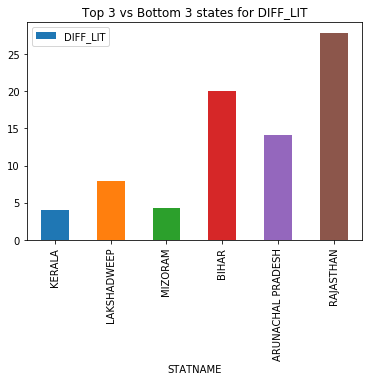

In [35]:
top_bottom.plot(y = 'DIFF_LIT',kind= 'bar')
plt.title('Top 3 vs Bottom 3 states for DIFF_LIT')

DIFF_LIT says a lot. The differences are really high in states with low overall literacy rates. So even if the bottom most states have good male literacy rates, female literacy rates are really low and that takes their overall literacy rate down. Thus these states really need to work on educating their females and increasing their literacy rate.

3. P_URB_POP

### [Step 3] Data Preparation:

Here will create `P_RUR_POP` which is 100 - urban population proportion. This will help us in comparing the rural and urban population proportions.

In [36]:
display_desc('P_URB_POP')

'Basic data from Census 2011: Percentage Urban Population'

In [37]:
top_bottom['P_RUR_POP'] = 100 - top_bottom['P_URB_POP']

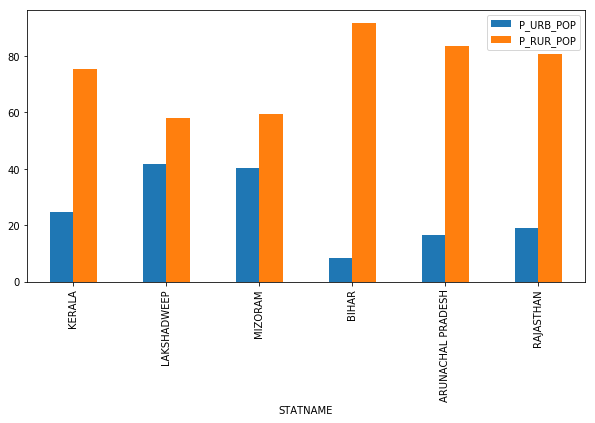

In [38]:
top_bottom.plot(y = ['P_URB_POP', 'P_RUR_POP'], kind = 'bar', figsize = (10,5))

Here we see a pretty obvious but important component that differentiates our top 3 and bottom 3 states. The difference between rural and urban population is much much bigger in the bottom 3.

The rural population percentage in the bottom 3 states is much more than the rural population percentage in the top 3. That's an important factor to note. People living in rural areas lead a very different life compared to the people living in urban areas. There is less motivation to go to school in rural areas as a lot of people tend to take up their parents profession or business. Also, often children are made to skip school and work at the farm.

4. SEXRATIO

Sex ratio is the no. of females per 1000 males

In [39]:
# Approximate National average 
elementary.SEXRATIO.mean()

930.8888888888889

In [40]:
top_bottom.SEXRATIO

STATNAME
KERALA               1084
LAKSHADWEEP           946
MIZORAM               975
BIHAR                 916
ARUNACHAL PRADESH     920
RAJASTHAN             926
Name: SEXRATIO, dtype: int64

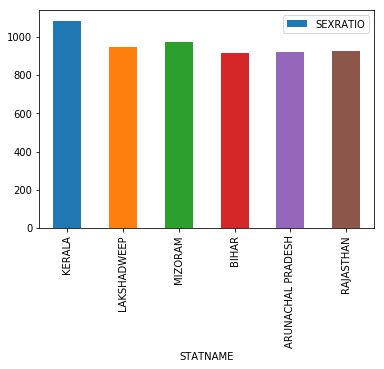

In [41]:
top_bottom.plot(y ='SEXRATIO', kind = 'bar')

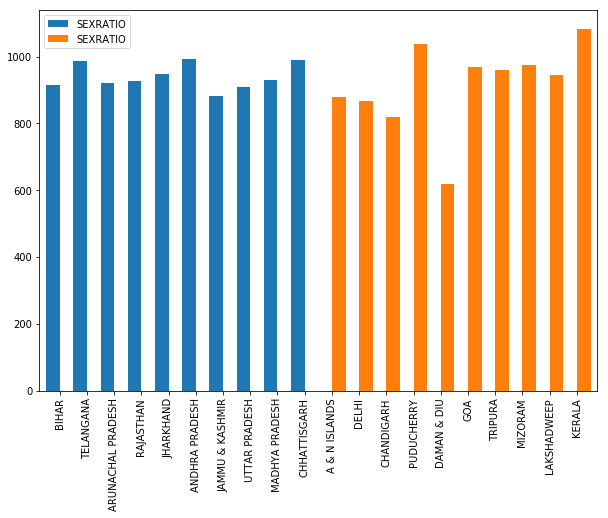

In [42]:
# Lets include more states in the comparison (considering the top and bottom 10 states)
elementary.sort_values(by = 'OVERALL_LI', inplace=True)
pd.concat([elementary.head(10),elementary.tail(10)], axis = 1, sort = False).plot(kind= 'bar', y = 'SEXRATIO', figsize = (10,7),width = 1)

In [43]:
elementary.loc[:,['SEXRATIO','OVERALL_LI']].corr()

,SEXRATIO,OVERALL_LI
SEXRATIO,1.000000,-0.037555
OVERALL_LI,-0.037555,1.000000


Clearly the sex ratio has nothing to do with the literacy level.The graphs dont show sex ratio affecting the literacy rate. Also the correlation's too weak. 

5. P_SC_POP and P_ST_POP

In [44]:
print(display_desc('P_SC_POP'))
print(display_desc('P_ST_POP'))

Basic data from Census 2011: Percentage SC Population
Basic data from Census 2011: Percentage ST Population


In [45]:
top_bottom['SC_ST_POP'] = top_bottom.P_SC_POP + top_bottom.P_ST_POP

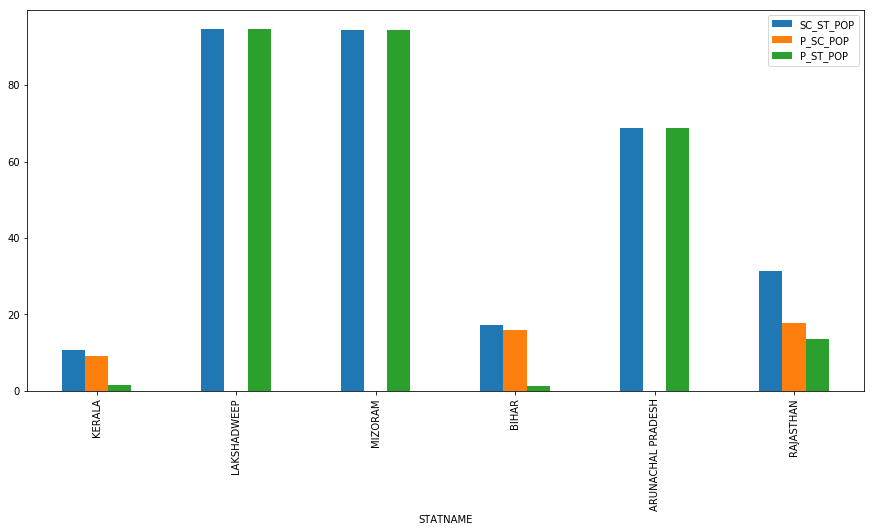

In [46]:
top_bottom.plot(y = ['SC_ST_POP','P_SC_POP','P_ST_POP'], kind = 'bar', figsize = (15,7))

Clearly, the overall literacy rate doesn't depend on the SC and ST population proportions because these are very different for all the above states.

Now we will try to analyse some school related features and see if they affect the overall literacy rate.

In [47]:
# These are all the 'school total' related variables that we can explore
meta_sch = meta_elementary[meta_elementary['Field name'].str.contains(r'^SCH\w*TOT')]
print(meta_sch)

    Field name                                        Description
28      SCHTOT                         Schools By Category: Total
37     SCHTOTG             Schools by Category: Government: Total
46     SCHTOTP               Schools by Category: Private : Total
55     SCHTOTM  Schools by Category: Madarsas & Unrecognised: ...
64    SCHTOTGR      Government Schools by Category - Rural: Total
73    SCHTOTGA    Schools by Category: Government & Aided : Total
82    SCHTOTPR         Private Schools by Category - Rural: Total
91   SCHBOYTOT              Schools by Category: Boys Only: Total
100  SCHGIRTOT             Schools by Category: Girls Only: Total


6. KIDSPERSCH (Kids per school)(For primary/elementary schools)

### [Step 3] Data Preparation:

We will be making `KIDSPERSCH` using `SCHKIDS`, `TOT_6_10_15` and `TOT_11_13_15` as this will let us check if the number of kids per school is a factor that determines the overall literacy rate or not.

In [48]:
display_desc('SCHTOT')

'Schools By Category: Total'

In [49]:
display_desc('TOT_6_10_15')

'Projected Population : Age Group 6 to 10'

In [50]:
display_desc('TOT_11_13_15')

'Projected Population : Age Group 11 to 13'

In [51]:
# Total no. of schools for the top 3 and bottom 3 states 
top_bottom.SCHTOT

STATNAME
KERALA                16458
LAKSHADWEEP              41
MIZORAM                3072
BIHAR                 80166
ARUNACHAL PRADESH      4012
RAJASTHAN            107931
Name: SCHTOT, dtype: int64

In [52]:
# No. of kids in the age group 6-15, i.e, elementary schoolkids
top_bottom['SCHKIDS'] = top_bottom.TOT_6_10_15 + top_bottom.TOT_11_13_15
# No. of kids per school
top_bottom['KIDSPERSCH'] = top_bottom.SCHKIDS/top_bottom.SCHTOT

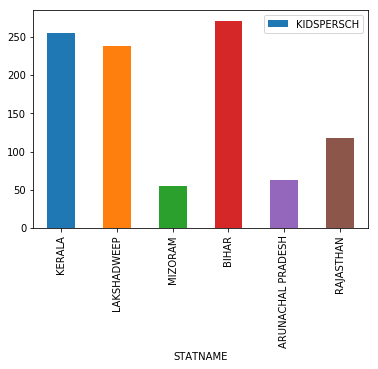

In [53]:
top_bottom.plot(y = 'KIDSPERSCH', kind = 'bar',)

We see that the no. of kids per school is not a good measure to differentiate between the top and bottom 3 states. Though Mizoram has has the lowest number of kids per school, Arunachal Pradesh and Rajasthan are closeby. Bihar has the max no. of kids per school. 

One reason why this measure failed to differentiate could be that we dont know the size of the schools and thus there could be really big schools in Kerala but really small schools (generally speaking) in Arunachal Pradesh. Thus we don't get to know the no. of students each school can enroll and manage effeciently. No. of teachers is too a huge factor here. Perhaps no. of classes or sections would have been a better measure here as we would have gotten to know the average class strength.

7. TOTCLS1g and KIDSPERCL

### [Step 3] Data Preparation:

We will making `KIDSPERCL` (Kids per class) as we think that it might be a better indicator of the overall literacy rate of the state.

In [54]:
display_desc('TOTCLS1G')

'Total Classrooms: Primary Only - Primary Only'

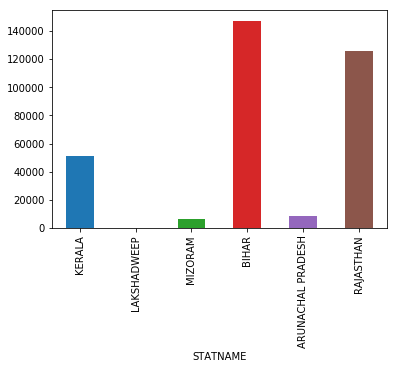

In [55]:
top_bottom['TOTCLS1G'].plot(kind= 'bar')

In [56]:
# primary kids per class
top_bottom['KIDSPERCL'] = top_bottom['SCHKIDS']/top_bottom['TOTCLS1G']

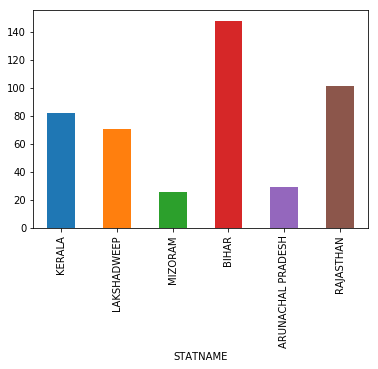

In [57]:
top_bottom['KIDSPERCL'].plot(kind= 'bar')

In [58]:
elem = elementary.copy(deep = True)
elem['SCHKIDS'] = elem.TOT_6_10_15 + elem.TOT_11_13_15
elem['KIDSPERCL'] = elem['SCHKIDS']/elem['TOTCLS1G']
elem.sort_values(by = 'OVERALL_LI',ascending = False,inplace = True)

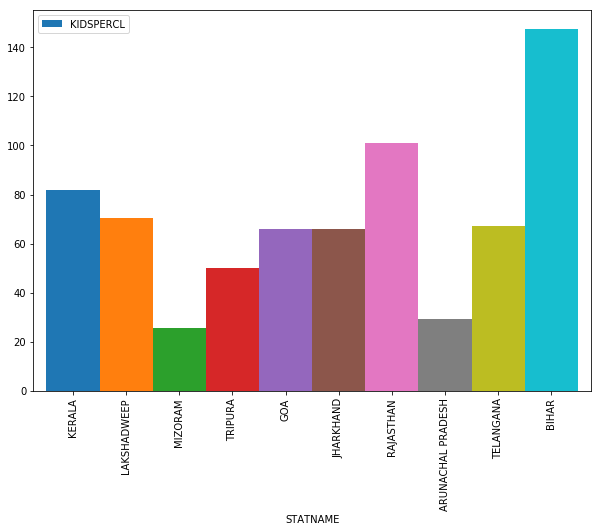

In [59]:
pd.concat([elem.head(5),elem.tail(5)], axis = 0, sort = False).plot(kind= 'bar', y = 'KIDSPERCL', figsize = (10,7),width = 1)

In [60]:
elem[['KIDSPERCL','OVERALL_LI']].corr()

,KIDSPERCL,OVERALL_LI
KIDSPERCL,1.00000,0.16714
OVERALL_LI,0.16714,1.00000


We see that there is a difference in the no. of kids per class, but it is nt significant.Though Bihar and Rajasthan have a very high no. of primary kids per class. The top 5 states on an average have lesser kids per class when compared to the bottom 5 states with the exception of Arunachal Pradesh.

8. Comparing the percentage of different types of Primary schools

### [Step 3] Data Preparation:

We can also take a look at the different types of schools in these states. It might be that the states having a high literacy rate have more private schools than govt. schools. For this purpose, we do some data preparation to allow for plotting of the type of schools.

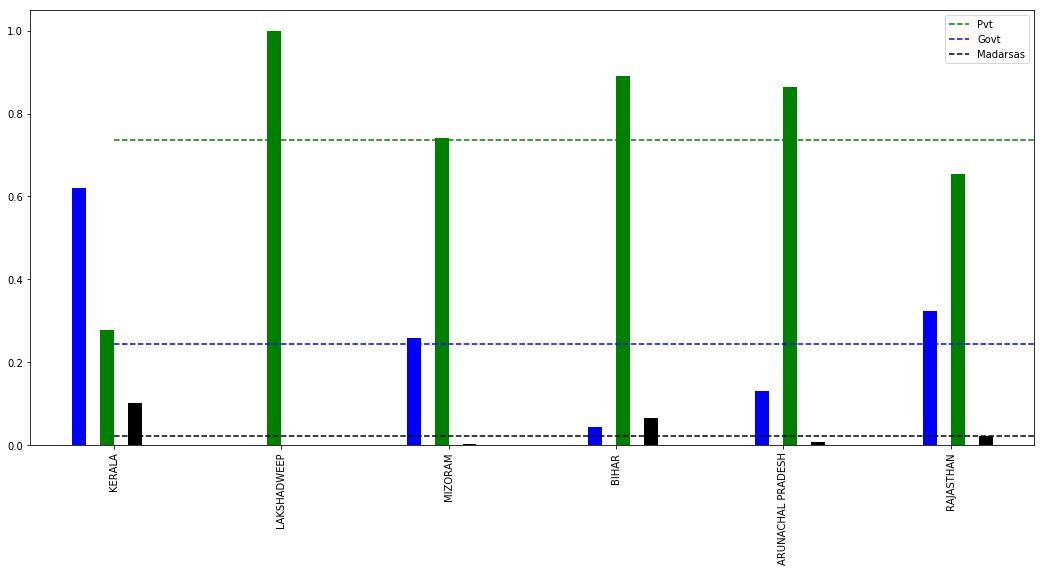

In [61]:
# Plot of the % of elementary private, govt schools and Madarsas and comparing them with the national avg.
schtotg_avg = (elementary.SCHTOTG/elementary.SCHTOT).mean()
schtotp_avg = (elementary.SCHTOTP/elementary.SCHTOT).mean()
schtotm_avg = (elementary.SCHTOTM/elementary.SCHTOT).mean()

top_3_elem['SCHTOTG_P'] = (top_3_elem.SCHTOTG/top_3_elem.SCHTOT)
top_3_elem['SCHTOTP_P'] = (top_3_elem.SCHTOTP/top_3_elem.SCHTOT)
top_3_elem['SCHTOTM_P'] = (top_3_elem.SCHTOTM/top_3_elem.SCHTOT)

bottom_3_elem['SCHTOTG_P'] = (bottom_3_elem.SCHTOTG/bottom_3_elem.SCHTOT)
bottom_3_elem['SCHTOTP_P'] = (bottom_3_elem.SCHTOTP/bottom_3_elem.SCHTOT)
bottom_3_elem['SCHTOTM_P'] = (bottom_3_elem.SCHTOTM/bottom_3_elem.SCHTOT)

pd.concat([top_3_elem, bottom_3_elem], axis = 1, sort = False).plot(y = ['SCHTOTP_P','SCHTOTG_P','SCHTOTM_P'],\
                                                                    figsize = (18,8), kind = 'bar',\
                                                                    color =['blue','blue','g','g','black','black'], \
                                                                       )

plt.plot([schtotg_avg]*8, linestyle ='--',color = 'g') # National avg for % of govt schools

plt.plot([schtotp_avg]*8, linestyle ='--',color = 'blue') # National avg for % of private schools

plt.plot([schtotm_avg]*8, linestyle ='--',color= 'black') # National avg for % of Madarsas

plt.legend(['Pvt','Govt','Madarsas'],loc = 1)

From here we can clearly note the following: 
* Lakshadweep has only govt schools.
* Kerala has the highest number of Pvt schools share in the total schools and is the only state here which has more Pvt schools than Govt schools. It has also got an exceptionally high number of Madarasa and the number of govt schools is much less than the national average.
* Bihar and Arunachal Pradesh have really less pvt schools compared to the govt schools. Their % of govt school is more than the national avg.
* Rajasthan has around 35% pvt schools which is large compared to its no. of govt schools.

All of this just shows us that even the share of pvt and govt schools isnt related to the literacy rate.

9. CONTIE

In [62]:
display_desc('CONTIE')

'Grants: School Development - Expended'

In [63]:
elem[['CONTIE','OVERALL_LI']].corr()

,CONTIE,OVERALL_LI
CONTIE,1.000000,-0.481281
OVERALL_LI,-0.481281,1.000000


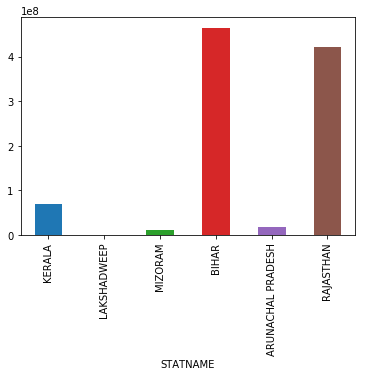

In [64]:
top_bottom.CONTIE.plot(kind = 'bar')

The above says that the more the overall literacy level is, the lesser the grants would have been given to the states for school development. That does make sense as states with lesser education standards and literacy level would be requiring lesser funds as they already have good infrastructure in place. It also depends on how many schools the state has or dense the population is. Lakshadweep, Mizoram and Arunachal Pradesh all are small states and thus their fund are minimal compared to Bihar and Rajasthans.

10. C9_B, C9_G, C8_B and C8_G

### [Step 3] Data Preparation:

Finally, here we calculate the dropout rate from class 8th to 9th. For that, we first sum up `C9_G` and `C9_B` to calculate the total no. of enrollments for class 9th. We do the same thing for class 8th. Then we subtract the total enrollments for class 9th from class 8th and divide this by the total enrollments for class 8th  to find out the proportion of students who dropped out from 8th to 9th

In [65]:
display_desc('C9_B')

'Enrolment By Grade: Boys - Grade 9'

In [66]:
display_desc('C9_G')

'Enrolment By Grade: Girls - Grade 9'

In [67]:
display_desc('C8_B')

'Enrolment By Grade: Boys - Grade 8'

In [68]:
display_desc('C8_G')

'Enrolment By Grade: Girls - Grade 8'

We can use the above 4 features to calculate the percentage of children dropping out in top 3 and bottom 3 states from class 8th to class 9th (primary to secondary).

In [69]:
elementary['C9_TOTAL'] = elementary.loc[:,'C9_B'] + elementary.loc[:,'C9_G']

In [70]:
elementary['C8_TOTAL'] = elementary.loc[:,'C8_B'] + elementary.loc[:,'C8_G']

In [71]:
elementary['DROP_8_9'] = (elementary.C8_TOTAL - elementary.C9_TOTAL)/elementary.C8_TOTAL

In [72]:
top_bottom_drop = pd.concat([elementary.sort_values('OVERALL_LI').tail(3).DROP_8_9, 
                             elementary.sort_values('OVERALL_LI').head(3).DROP_8_9], axis = 0)

In [73]:
top_bottom_drop

STATNAME
MIZORAM             -0.025558
LAKSHADWEEP         -0.292279
KERALA              -0.038128
BIHAR                0.216246
TELANGANA            0.038714
ARUNACHAL PRADESH    0.102825
Name: DROP_8_9, dtype: float64

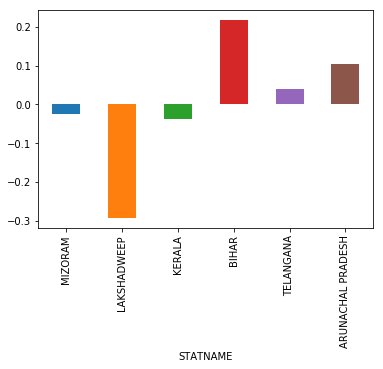

In [74]:
top_bottom_drop.plot(kind='bar', y = 'DROP_8_9', x = 'STATNAME')

In [75]:
elementary[['DROP_8_9','OVERALL_LI']].corr()

,DROP_8_9,OVERALL_LI
DROP_8_9,1.000000,-0.703246
OVERALL_LI,-0.703246,1.000000


We find the drop out rate from 8th to 9th(primary to secondary) a pretty important feature in distinguishing between the top 3 and bottom 3 states. It is an obvious reason but no one knew that there would be this much of a difference. The top 3 states have more admissions in 9th than they had in 8th while the bottom 3 have the opposite going on. 

Thus, the key takeaways would be from this analysis would be :

* States should try to increase their female literacy rate by  making it safer for girls to travel, making girl only schools with female teachers, providing special incentives to the families to get their girl child to omplete her schooling etc.
* People living in rural areas lead a very different life compared to the people living in urban areas. There is less motivation to go to school in rural areas as a lot of people tend to take up their parent's profession or business. Also, often children are made to skip school and work at the farm. The state should provide more incentives to ensure that families living in rural areas get their children to complete their schooling.
* Dropout rate from 8th to 9th class should be decreased and schemes should be made to ensure that this dropout rate declines. Causes for this dropout rate should be looked into and be dealt with.

## 3. Which class is the dropout rate maximum in ?

### [Step 3] Data Preparation:

To answer our final question, we must calculate the dropout rates for all classes given in the dataset. So we start by summing up the boys and the girls enrollment for each class. We form a dataframe out of this and then take the sum for each class, i.e, sum up total enrollments for all states. Then we calculate the dropout rate for each class and plot it

In [76]:
# setting the index as state name for easy coding
elementary.set_index('STATNAME', inplace = True)

In [77]:
# class_columns contains all the columns related to class enrollments
class_b_columns = elementary.columns[elementary.columns.str.contains('C\d_[B]$',case = False, regex = True)].tolist()
class_g_columns = elementary.columns[elementary.columns.str.contains('C\d_[G]$',case = False, regex = True)].tolist()

In [78]:
# total enrollments in each class
sums_classes_df = pd.DataFrame(np.matrix(elementary[class_b_columns]) + np.matrix(elementary[class_g_columns]))

In [79]:
# storing the column names and index for above dataframe
sums_classes_cols=[i[:2] for i in class_b_columns]
sums_classes_index = elementary.index

In [80]:
sums_classes_df.index = sums_classes_index
sums_classes_df.columns = sums_classes_cols

In [81]:
# totalling for columns
totals = sums_classes_df.sum(axis = 0)

In [82]:
dropout = []
for i,_ in enumerate(totals):
    try: 
        dropout.append((totals[i] - totals[i+1])/totals[i])
    except:
        pass

In [83]:
dropout

[0.049807894807547,
 0.014726304017832778,
 -0.008486844753752712,
 0.023597734638681263,
 0.08056395873036064,
 0.019658139068640237,
 0.026063321302817914,
 0.06841362994279623]

<BarContainer object of 8 artists>

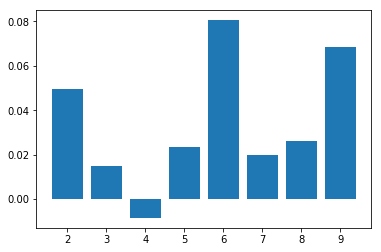

In [84]:
plt.bar(x = range(2,10,1),height = dropout)

We see from this given graph that the dropout rate was maximum in the 6th class followed by the 9th class and 2nd class. Class 4 saw a negative dropout rate, i.e, more students enrolled and less dropped out when moving from class 3 to class 4 and that is some really good news !

The dropout rate for 5th to 6th was really high, 8.5%. One reason for this could be that when the child is old enough to be in 5th, he is usually old enough to do a lot of other work too. His parents might need him at the farm or at their business to help them and start earning. This is a huge problem, especially in the rural parts of India. An additional step here could be to compare the dropout rates between the rural and urban schools.

### We don't have a [Step 4] becuase we haven't modelled our data.

### [Step 5] Results and Conclusions :

We started out with a comparison of the literacy rates in the different states and union territories in India. We compared the Male and Female literacy rates in these states and saw that there was a huge difference in the states with a low overall literacy rate. The top 3 states were Kerala, Lakshadweep and Mizoram and the bottom 3 were Bihar, Telngana and Arunachal Pradesh.

Next we saw that difference in male and female literacy rates, rural population proportion and dropout rates from 8th to 9th class played a huge role in separating the top 3 and bottom 3 states.

Finally, the dropout rates in different classes were explored and while the dropout rate for 6th class was really high, more students had enrolled in class 4 than had dropped out.

The literacy rate in India has been improving but there are some key issues that need to be tackled aggressively in order to improve the state of education in India. This is not just the job of the govt, but it is the duty of each and everyone living in the country. Hope to see the stats showing a much better India in the future.

## Yay. Done !! 